In [5]:
import csv
import pandas as pd
import rustworkx as rx
from rustworkx.visualization import graphviz_draw
from qiskit_ibm_provider import IBMProvider,least_busy

provider = IBMProvider()

In [9]:
#バックエンド（量子コンピュータ）を取得
backend = least_busy(provider.backends(
    simulator=False,
    operational=True,
    open_pulse=True,
    dynamic_reprate_enabled = True,
    filters=lambda b: b.max_shots > 8000
))
print(backend.name)

ibm_kawasaki


In [10]:
backend_config = backend.configuration()
backend_property = backend.properties()
print("バックエンド名:", backend.name)
print("ベーシック二量子gate:", backend.basis_gates[0])
print("ベーシックgate:", backend.basis_gates)
print("不使用gate条件:",backend_property.faulty_gates())
print("不使用qubit条件:",backend_property.faulty_qubits())
print("qubit数:",backend_config.n_qubits)
print("バックエンドバージョン:",backend_property.backend_version)
print("キャリブレーション日時:",backend_property.last_update_date)

バックエンド名: ibm_kawasaki
ベーシック二量子gate: ecr
ベーシックgate: ['ecr', 'id', 'rz', 'sx', 'x']
不使用gate条件: []
不使用qubit条件: []
qubit数: 127
バックエンドバージョン: 2.1.11
キャリブレーション日時: 2024-02-11 12:40:52+09:00


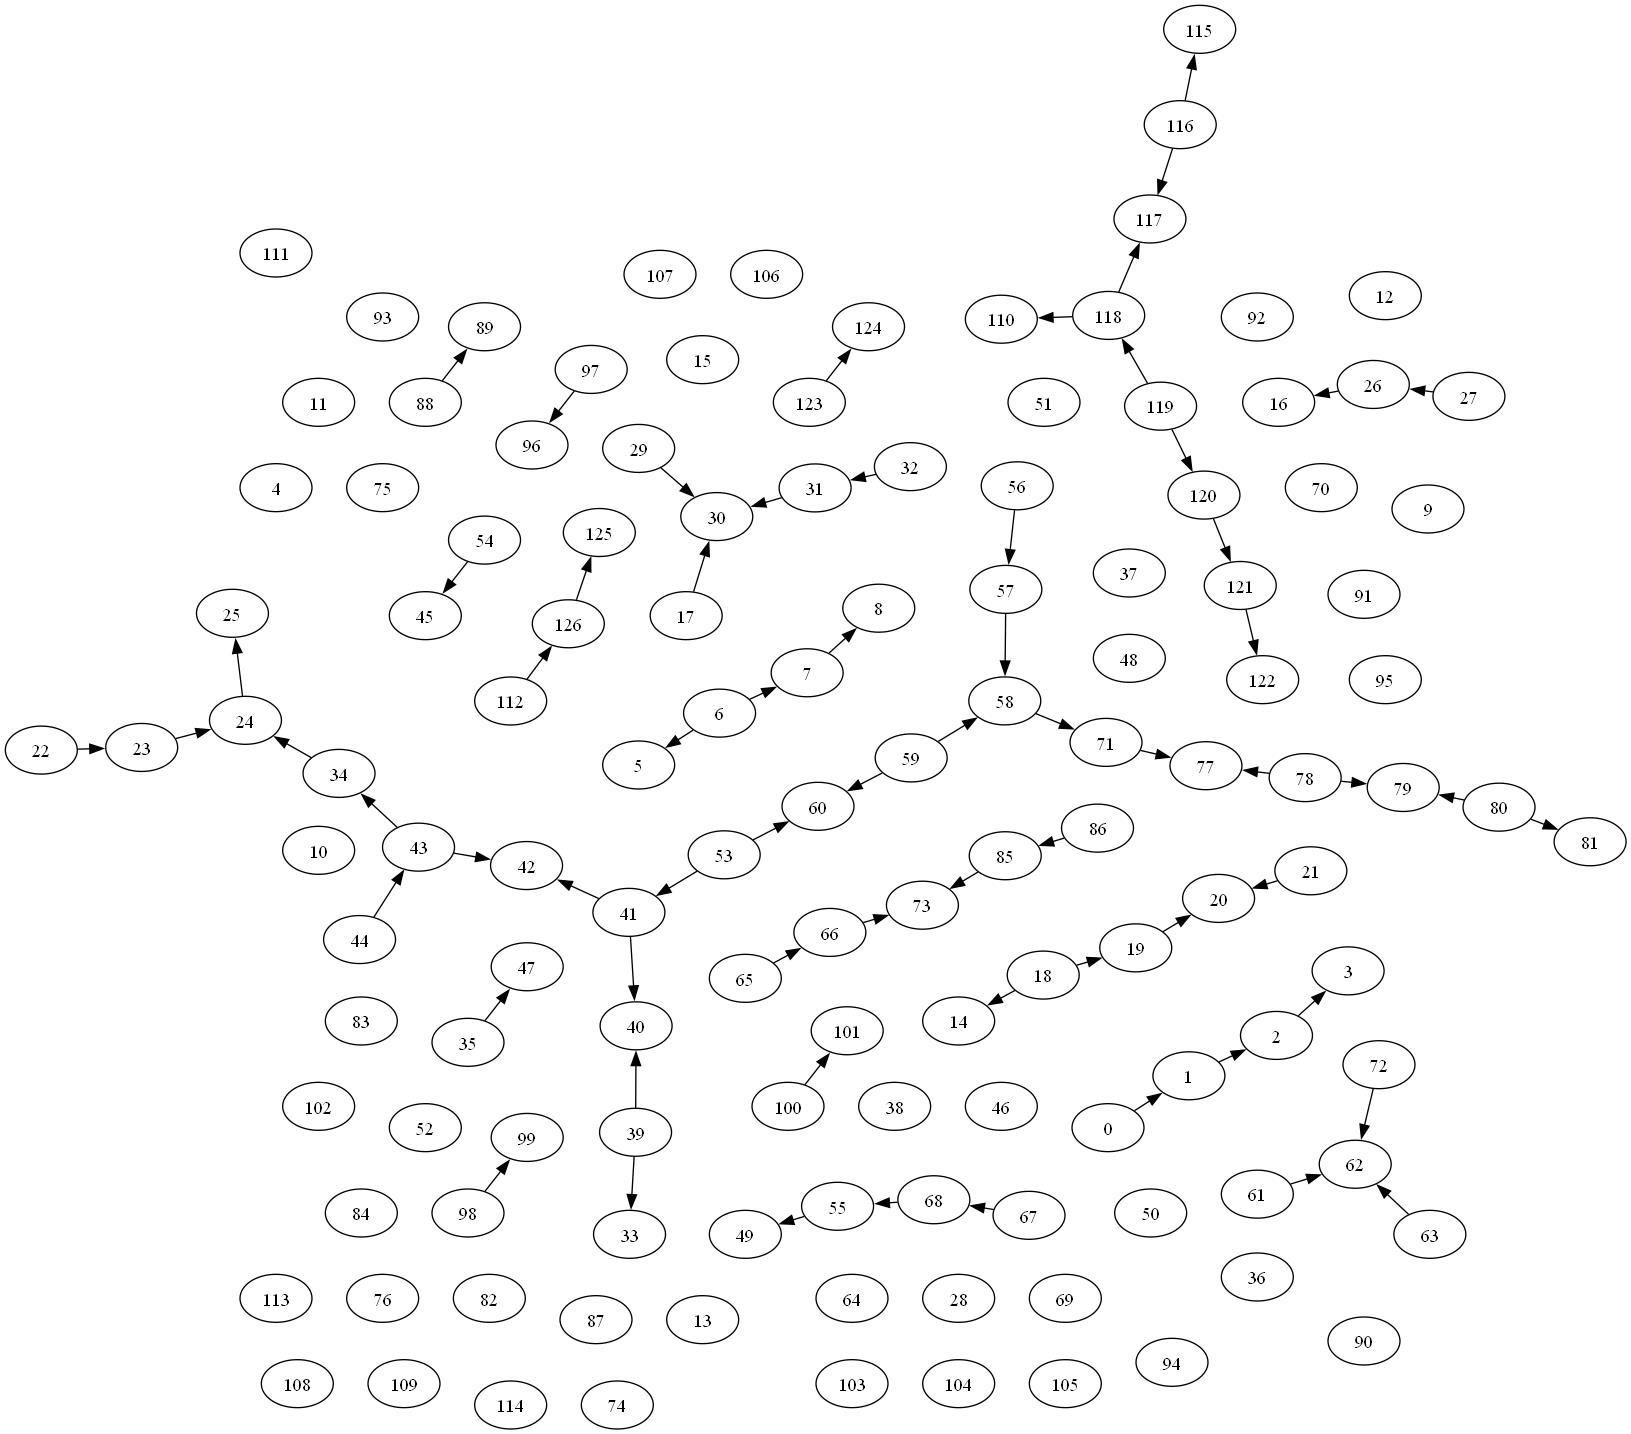

In [11]:
threshold = 0.0075
# 2量子ゲートデータ
data = [["gate", "tuple", "error"]]
for tuple_i in backend.coupling_map.get_edges():
    data.append([str(backend.basis_gates[0]),tuple_i,backend_property.gate_error(backend.basis_gates[0],tuple_i)])
# CSVファイルへの書き込み
with open("errors.csv", 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerows(data)

filtered_data = [row for row in data if isinstance(row[2], float) and row[2] <= threshold]
meta_data = ["gate", "tuple", "error"]
# CSVファイルへの書き込み
with open("f_errors.csv", 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(meta_data)
    writer.writerows(filtered_data)

#フィルターリストの制作
import ast
df = pd.read_csv("f_errors.csv", encoding="SHIFT_JIS")
filtered_list = list(df["tuple"])
filtered_list_2 =[]
for tuple_i in filtered_list:
    newtuple=ast.literal_eval(tuple_i)
    filtered_list_2.append(newtuple)
G =rx.PyDiGraph()
G.add_nodes_from(range(backend_config.n_qubits))
for tuple_i in filtered_list_2:
    G.add_edge(tuple_i[0],tuple_i[1],backend_property.gate_error(backend.basis_gates[0],tuple_i)*100)
graphviz_draw(G,image_type="jpeg",method="neato")